### Import Libraries

In [1]:
#pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org scikeras

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold,train_test_split,cross_val_score,GridSearchCV
from sklearn.metrics import mean_squared_error,r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import softmax,relu,sigmoid
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.losses import BinaryCrossentropy,MeanSquaredError,MeanAbsoluteError,MeanAbsolutePercentageError
from scikeras.wrappers import KerasRegressor

import warnings
warnings.filterwarnings('ignore')

### Import Data

In [2]:
gt=pd.read_csv('gas_turbines.csv')
gt.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,6.8594,1007.9,96.799,3.5000,19.663,1059.2,550.00,114.70,10.605,3.1547,82.722
1,6.7850,1008.4,97.118,3.4998,19.728,1059.3,550.00,114.72,10.598,3.2363,82.776
2,6.8977,1008.8,95.939,3.4824,19.779,1059.4,549.87,114.71,10.601,3.2012,82.468
3,7.0569,1009.2,95.249,3.4805,19.792,1059.6,549.99,114.72,10.606,3.1923,82.670
4,7.3978,1009.7,95.150,3.4976,19.765,1059.7,549.98,114.72,10.612,3.2484,82.311


### Data Understanding

In [3]:
gt.shape

(15039, 11)

In [4]:
gt.isna().sum()

AT      0
AP      0
AH      0
AFDP    0
GTEP    0
TIT     0
TAT     0
TEY     0
CDP     0
CO      0
NOX     0
dtype: int64

In [5]:
gt.dtypes

AT      float64
AP      float64
AH      float64
AFDP    float64
GTEP    float64
TIT     float64
TAT     float64
TEY     float64
CDP     float64
CO      float64
NOX     float64
dtype: object

In [6]:
gt[gt.duplicated()]

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX


### Data Visualization

#### Dist and Box Plots for Features (Continuous Data)

AT


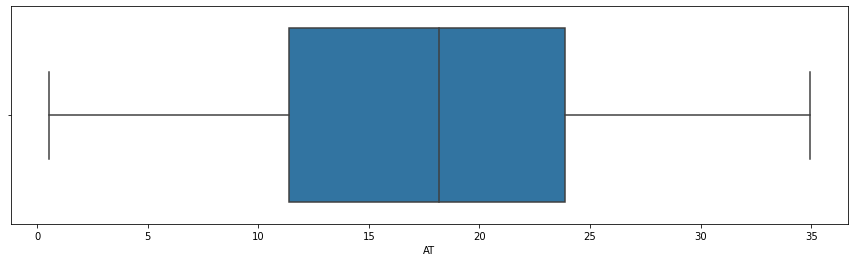

AP


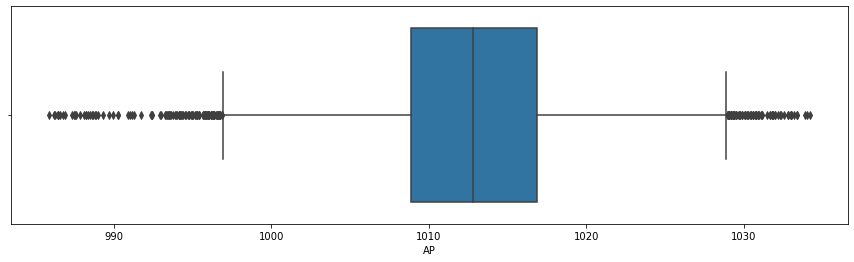

AH


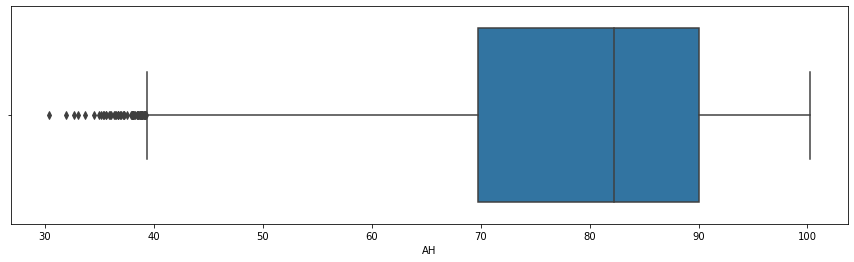

AFDP


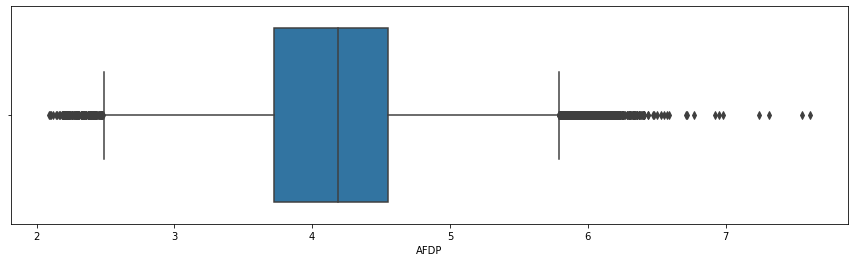

GTEP


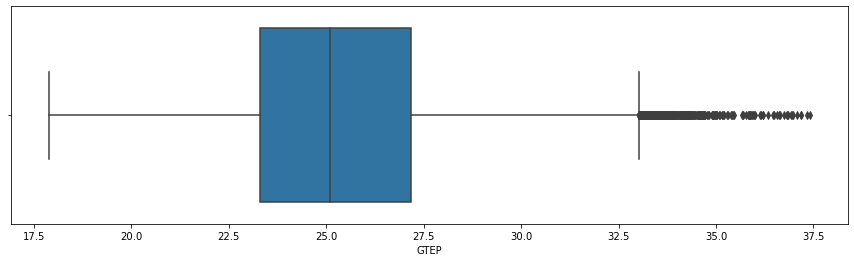

TIT


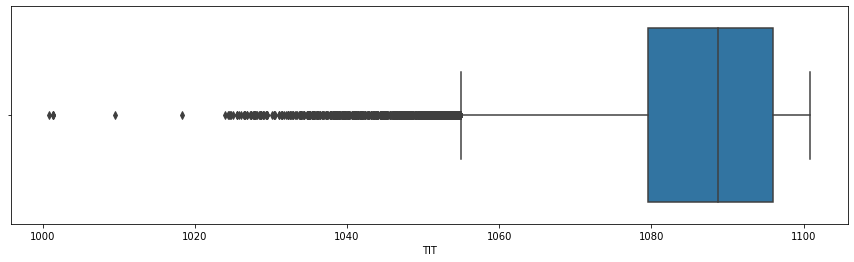

TAT


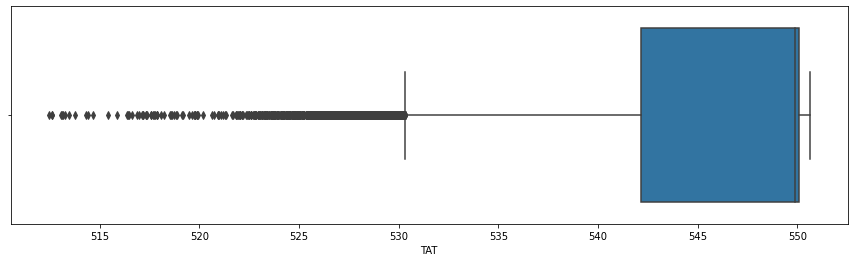

TEY


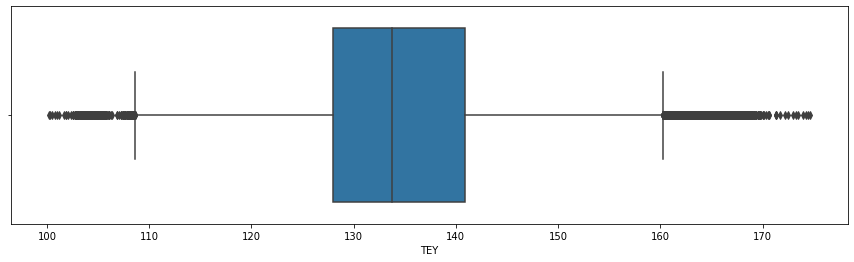

CDP


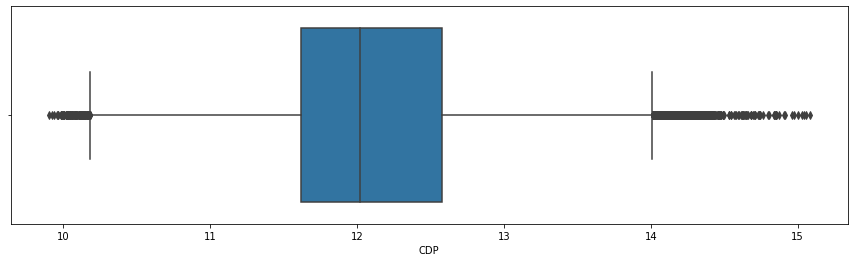

CO


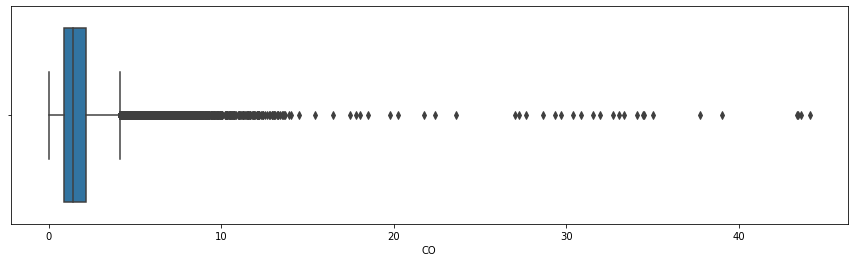

NOX


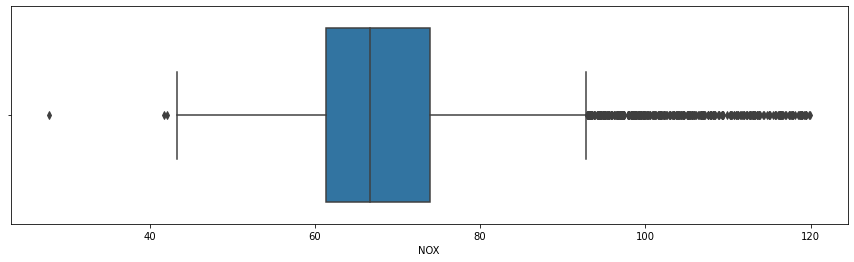

In [7]:
for i in gt.columns:
    print(i)
    plt.figure(figsize=(15,4))
    sns.boxplot(gt[i])
    plt.show()

AT


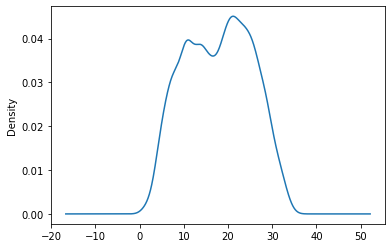

AP


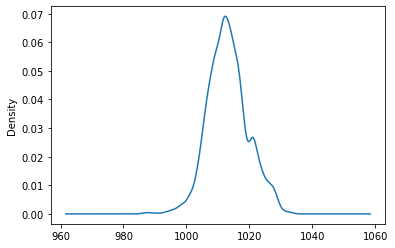

AH


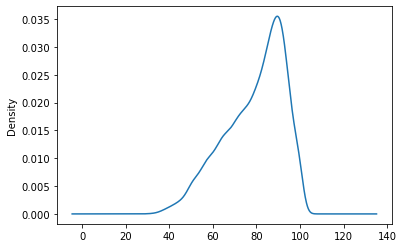

AFDP


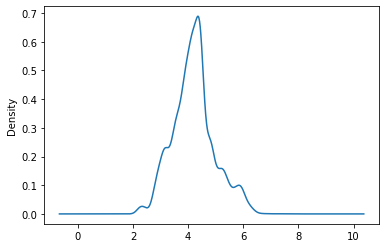

GTEP


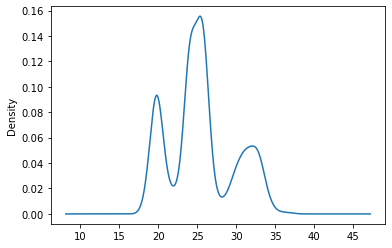

TIT


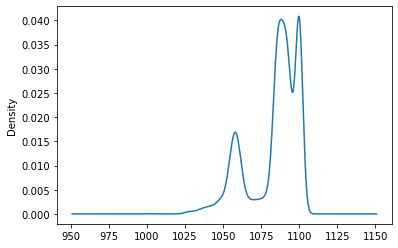

TAT


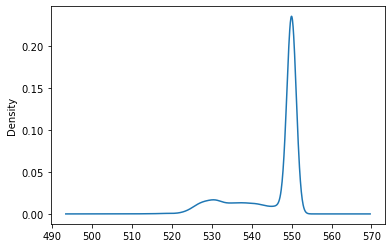

TEY


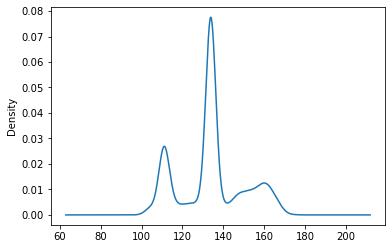

CDP


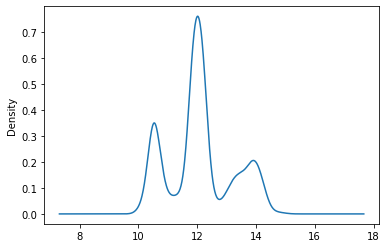

CO


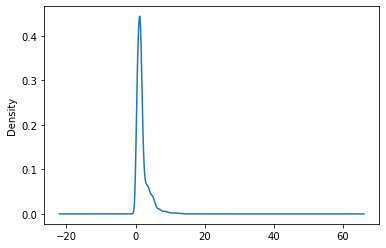

NOX


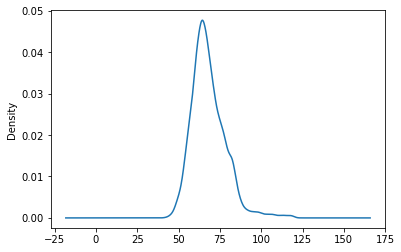

In [8]:
for i in gt.columns:
    print(i)
    gt[i].plot(kind='kde')
    plt.show()

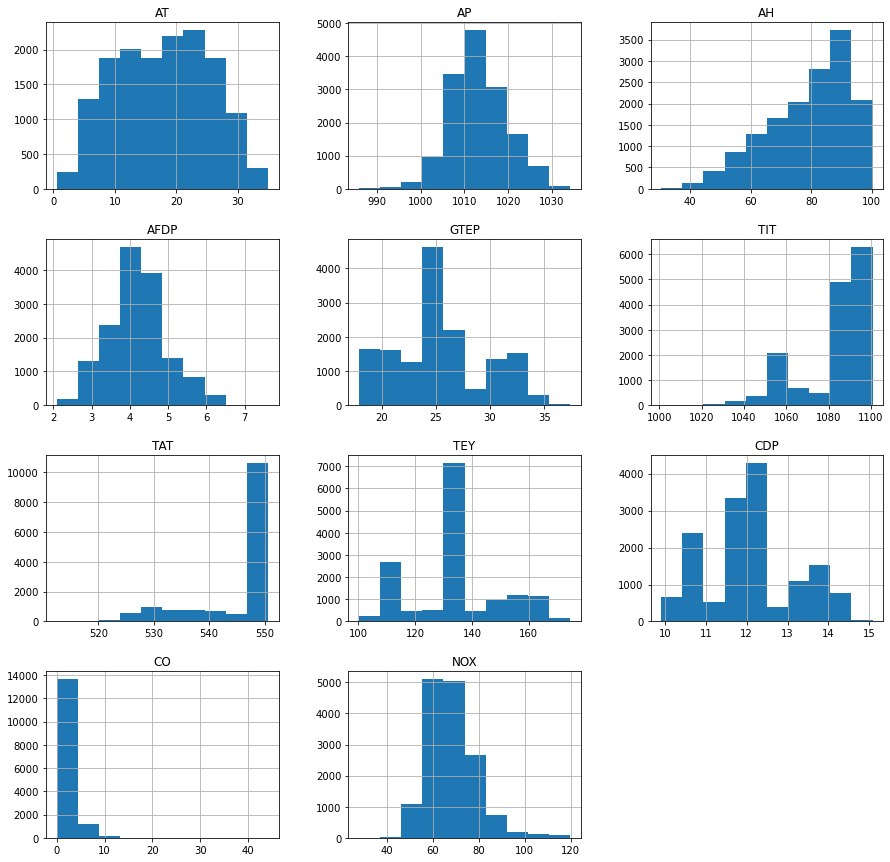

In [9]:
gt.hist(figsize=(15,15),)
plt.show()

In [10]:
#Correlation Metrics
corr=gt.corr().round(2)
np.fill_diagonal(corr.values,0)
corr

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
AT,0.00,-0.41,-0.55,-0.10,-0.05,0.09,0.34,-0.21,-0.10,-0.09,-0.60
AP,-0.41,0.00,0.04,0.04,0.08,0.03,-0.22,0.15,0.13,0.04,0.26
AH,-0.55,0.04,0.00,-0.12,-0.20,-0.25,0.01,-0.11,-0.18,0.17,0.14
AFDP,-0.10,0.04,-0.12,0.00,0.74,0.63,-0.57,0.72,0.73,-0.33,-0.04
GTEP,-0.05,0.08,-0.20,0.74,0.00,0.87,-0.76,0.98,0.99,-0.51,-0.21
TIT,0.09,0.03,-0.25,0.63,0.87,0.00,-0.36,0.89,0.89,-0.69,-0.23
TAT,0.34,-0.22,0.01,-0.57,-0.76,-0.36,0.00,-0.72,-0.74,0.06,0.01
TEY,-0.21,0.15,-0.11,0.72,0.98,0.89,-0.72,0.00,0.99,-0.54,-0.10
CDP,-0.10,0.13,-0.18,0.73,0.99,0.89,-0.74,0.99,0.00,-0.52,-0.17
CO,-0.09,0.04,0.17,-0.33,-0.51,-0.69,0.06,-0.54,-0.52,0.00,0.32


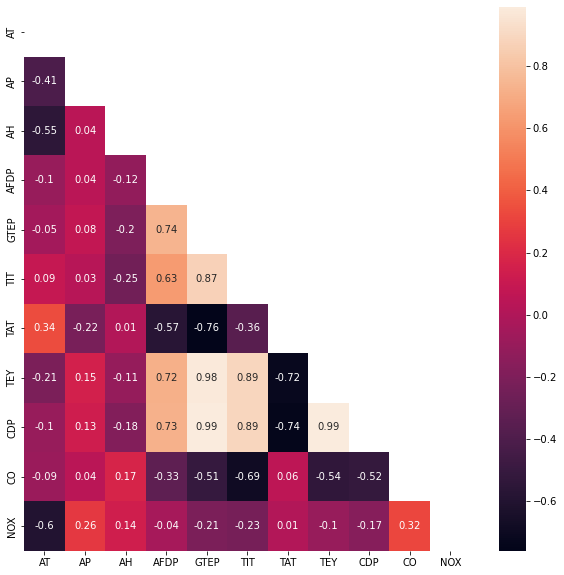

In [11]:
plt.figure(figsize=(10,10))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,annot=True,mask=mask)
plt.show()

#### There is multi collinearity in the dataset

### Data Preparation

In [12]:
X=gt.drop('TEY',axis=1)
y=gt[['TEY']]

In [13]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=12)

In [14]:
ss=StandardScaler()
scaled_X_train=ss.fit_transform(X_train)
scaled_X_test=ss.fit_transform(X_test)

In [15]:
scaled_X_train.shape,scaled_X_test.shape,y_train.shape,y_test.shape

((10527, 10), (4512, 10), (10527, 1), (4512, 1))

### Model Building

### CROSS VALIDATION TECHNIQUE

In [16]:
def basemodel():
    model=Sequential()
    model.add(Dense(units=64,input_dim=10,activation='tanh'))
    model.add(Dense(units=32,activation='relu'))
    model.add(Dense(units=32,activation='relu'))
    model.add(Dense(units=1))
    adam=Adam(learning_rate=0.01)
    model.compile(loss='mean_squared_error',metrics=["mean_squared_error"],optimizer=adam)
    return model

In [17]:
estimator=KerasRegressor(build_fn=basemodel,verbose=0)
batch_size = [50,100,200,300]
epochs = [50,100,150,200]
param_grid = dict(batch_size=batch_size,epochs=epochs)
grid=GridSearchCV(estimator=estimator,param_grid=param_grid,cv=KFold(),verbose=10)

In [18]:
grid_results=grid.fit(scaled_X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5; 1/16] START batch_size=50, epochs=50...................................
[CV 1/5; 1/16] END ....batch_size=50, epochs=50;, score=0.997 total time=  26.1s
[CV 2/5; 1/16] START batch_size=50, epochs=50...................................
[CV 2/5; 1/16] END ....batch_size=50, epochs=50;, score=0.992 total time=  27.0s
[CV 3/5; 1/16] START batch_size=50, epochs=50...................................
[CV 3/5; 1/16] END ....batch_size=50, epochs=50;, score=0.998 total time=  26.1s
[CV 4/5; 1/16] START batch_size=50, epochs=50...................................
[CV 4/5; 1/16] END ....batch_size=50, epochs=50;, score=0.994 total time=  26.9s
[CV 5/5; 1/16] START batch_size=50, epochs=50...................................
[CV 5/5; 1/16] END ....batch_size=50, epochs=50;, score=0.979 total time=  29.0s
[CV 1/5; 2/16] START batch_size=50, epochs=100..................................
[CV 1/5; 2/16] END ...batch_size=50, epochs=100;

In [19]:
grid_results.best_score_

0.9974752183448118

In [20]:
grid_results.best_params_

{'batch_size': 50, 'epochs': 150}

### Model Building with Best Parameters

In [21]:
model=Sequential()
model.add(Dense(units=32,activation='relu',input_dim=10))
model.add(Dense(units=64,activation='relu'))
model.add(Dense(units=96,activation='relu'))
model.add(Dense(units=32,activation='relu'))
model.add(Dense(units=64,activation='relu'))
model.add(Dense(units=96,activation='relu'))
model.add(Dense(units=1))
model.summary()

Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_324 (Dense)           (None, 32)                352       
                                                                 
 dense_325 (Dense)           (None, 64)                2112      
                                                                 
 dense_326 (Dense)           (None, 96)                6240      
                                                                 
 dense_327 (Dense)           (None, 32)                3104      
                                                                 
 dense_328 (Dense)           (None, 64)                2112      
                                                                 
 dense_329 (Dense)           (None, 96)                6240      
                                                                 
 dense_330 (Dense)           (None, 1)               

In [23]:
adam=Adam(learning_rate=0.01)
model.compile(optimizer=adam,loss='mean_squared_error',metrics=["mean_squared_error"])

In [24]:
model_history=model.fit(X_train,y_train,epochs=150,batch_size=50,validation_split=0.3)

Epoch 1/150
148/148 [==============================] - 2s 4ms/step - loss: 1420.2274 - mean_squared_error: 1420.2274 - val_loss: 162.4796 - val_mean_squared_error: 162.4796
Epoch 2/150
148/148 [==============================] - 0s 3ms/step - loss: 68.9385 - mean_squared_error: 68.9385 - val_loss: 6.6893 - val_mean_squared_error: 6.6893
Epoch 3/150
148/148 [==============================] - 0s 2ms/step - loss: 9.7121 - mean_squared_error: 9.7121 - val_loss: 29.3900 - val_mean_squared_error: 29.3900
Epoch 4/150
148/148 [==============================] - 0s 3ms/step - loss: 51.7672 - mean_squared_error: 51.7672 - val_loss: 8.2136 - val_mean_squared_error: 8.2136
Epoch 5/150
148/148 [==============================] - 0s 3ms/step - loss: 10.5862 - mean_squared_error: 10.5862 - val_loss: 5.6940 - val_mean_squared_error: 5.6940
Epoch 6/150
148/148 [==============================] - 0s 3ms/step - loss: 4.3105 - mean_squared_error: 4.3105 - val_loss: 3.4457 - val_mean_squared_error: 3.4457
Epoc

### Model Evaluation

In [25]:
model.evaluate(X_test,y_test)

141/141 [==============================] - 0s 1ms/step - loss: 2.4367 - mean_squared_error: 2.4367


[2.436682939529419, 2.436682939529419]

In [26]:
model_history.history.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

### Model Testing

In [27]:
y_pred_test=model.predict(X_test)
y_pred_train=model.predict(X_train)

329/329 [==============================] - 0s 1ms/step


### Model Evaluation

In [28]:
test_predictions=pd.DataFrame()
test_predictions['Actual']=y_test
test_predictions['Predicted']=y_pred_test
test_predictions

,Actual,Predicted
4841,112.06,111.500450
6730,127.18,127.395309
7694,132.70,133.204727
9566,159.95,161.024857
6017,132.85,133.030640
...,...,...
8007,133.56,133.649994
5394,133.73,134.369003
14601,112.90,114.310516
917,159.87,162.726822


In [29]:
train_predictions=pd.DataFrame()
train_predictions['Actual']=y_train
train_predictions['Predicted']=y_pred_train
train_predictions

,Actual,Predicted
11629,150.96,151.000488
4597,110.78,112.559715
4532,134.78,136.271530
7531,133.05,132.954147
11594,113.18,115.513443
...,...,...
7409,113.45,118.883675
3325,132.67,133.159134
9606,133.68,133.697632
5787,110.04,111.176735


### Model Performance - Training Vs Test Loss

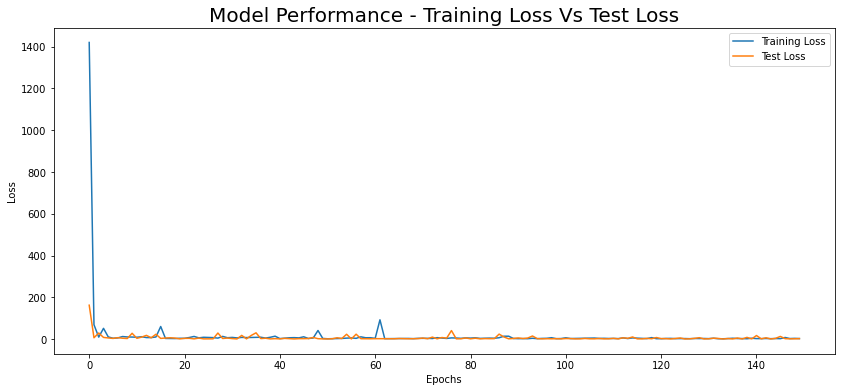

In [30]:
plt.figure(figsize=(14,6))
plt.plot(model_history.history['loss'],label = 'Training Loss')
plt.plot(model_history.history['val_loss'],label = 'Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Performance - Training Loss Vs Test Loss',size = 20)
plt.legend()
plt.show()

### Model Performance - Training Vs Test mean_squared_error

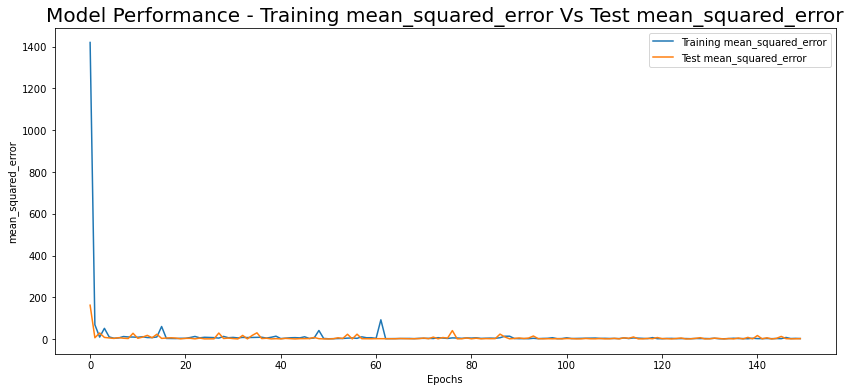

In [31]:
plt.figure(figsize=(14,6))
plt.plot(model_history.history['mean_squared_error'],label = 'Training mean_squared_error')
plt.plot(model_history.history['val_mean_squared_error'],label = 'Test mean_squared_error')
plt.xlabel('Epochs')
plt.ylabel('mean_squared_error')
plt.title('Model Performance - Training mean_squared_error Vs Test mean_squared_error',size = 20)
plt.legend()
plt.show()

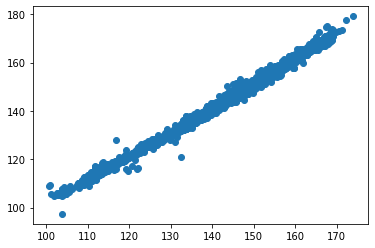

In [32]:
plt.scatter(y_test,y_pred_test)
plt.show()

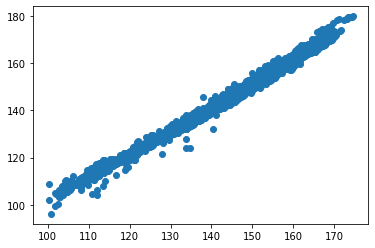

In [33]:
plt.scatter(y_train,y_pred_train)
plt.show()

In [34]:
mean_squared_error(y_train,y_pred_train)

2.4221960125654594

In [35]:
mean_squared_error(y_test,y_pred_test)

2.4366833163068953

In [36]:
r2_score(y_train,y_pred_train)

0.9903520989730379

In [37]:
r2_score(y_test,y_pred_test)

0.9902297028637188

#### R2 score is very high, means our model is doing pretty good job

### End !!!